In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv


In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))


    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if legend:
      plt.legend(legend)

    plt.title(title)
    plt.grid(True)
    plt.show()


In [3]:
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2023-09-06 08:05:20--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.207, 209.85.200.207, 142.250.136.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2023-09-06 08:05:20 (94.1 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [4]:
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


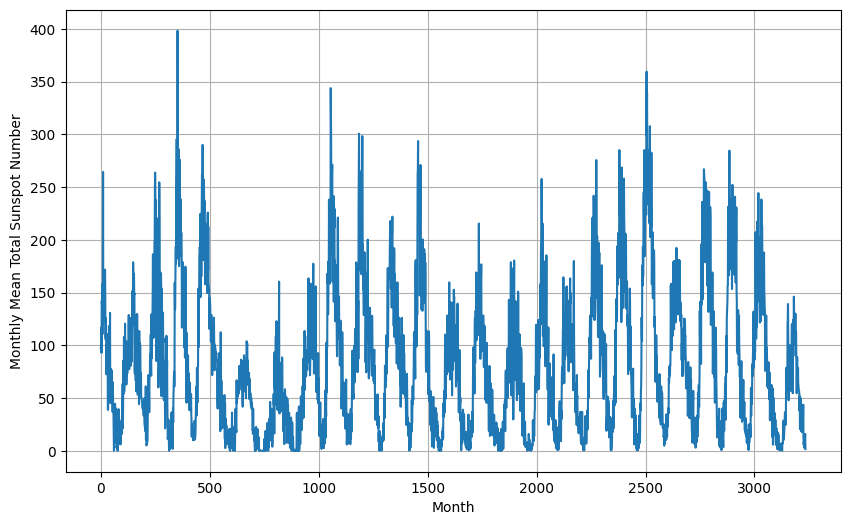

In [5]:
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

time = np.array(time_step)
series = np.array(sunspots)

plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')


In [6]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [8]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


In [11]:
init_weights = model.get_weights()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 15s 15ms/step - loss: 61.0437 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 41.6646 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 31.8349 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 28.5659 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 8ms/step - loss: 27.3566 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 9ms/step - loss: 26.4455 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 25.7152 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 12ms/step - loss: 24.1792 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 13ms/step - loss: 23.6843 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 9ms/step - loss: 23.4653 - lr: 2.8184e-08
Epoch 11/100
93

(1e-08, 0.001, 0.0, 100.0)

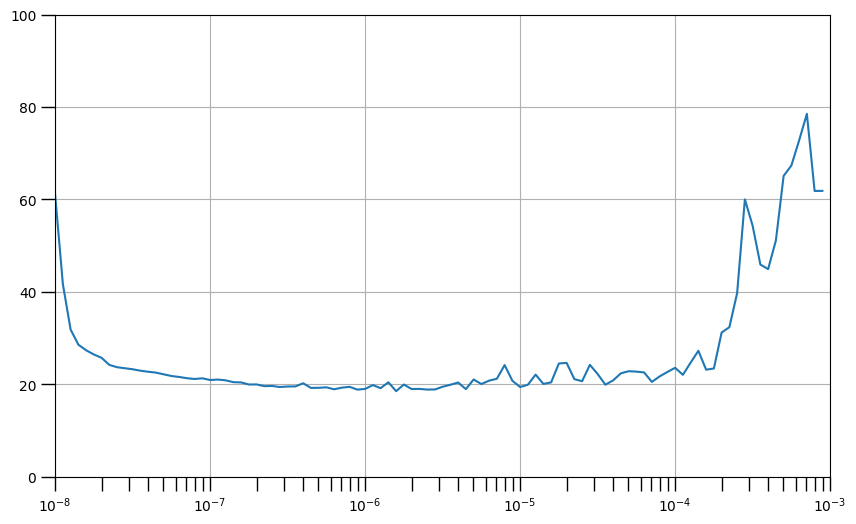

In [12]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 100])


In [13]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)


In [14]:

learning_rate = 1e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 5s 9ms/step - loss: 26.7594 - mae: 27.2551
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 21.5688 - mae: 22.0645
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 20.2981 - mae: 20.7936
Epoch 4/100
93/93 [==============================] - 1s 10ms/step - loss: 20.0622 - mae: 20.5561
Epoch 5/100
93/93 [==============================] - 1s 9ms/step - loss: 19.4474 - mae: 19.9397
Epoch 6/100
93/93 [==============================] - 1s 9ms/step - loss: 19.7124 - mae: 20.2061
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 19.6428 - mae: 20.1364
Epoch 8/100
93/93 [==============================] - 1s 9ms/step - loss: 20.0097 - mae: 20.5020
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 19.4606 - mae: 19.9538
Epoch 10/100
93/93 [==============================] - 1s 11ms/step - loss: 18.8533 - mae: 19.3471
Epoch 11/100
93/93 [=================

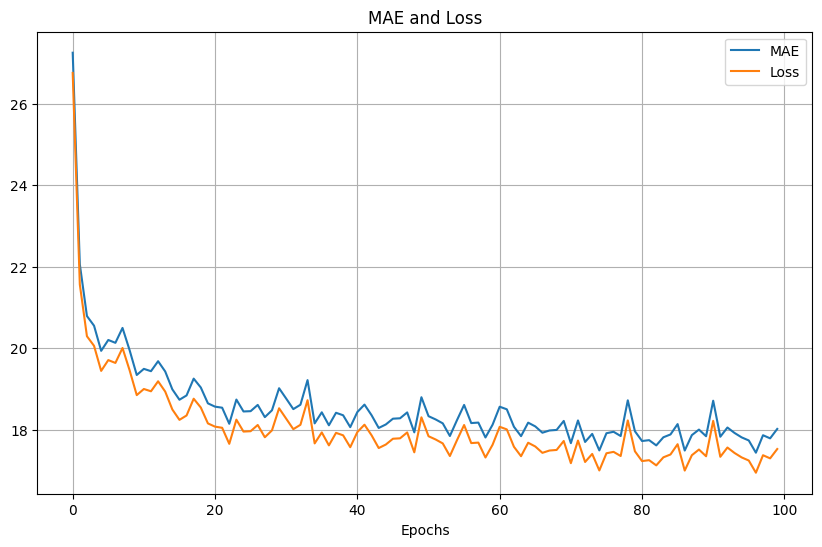

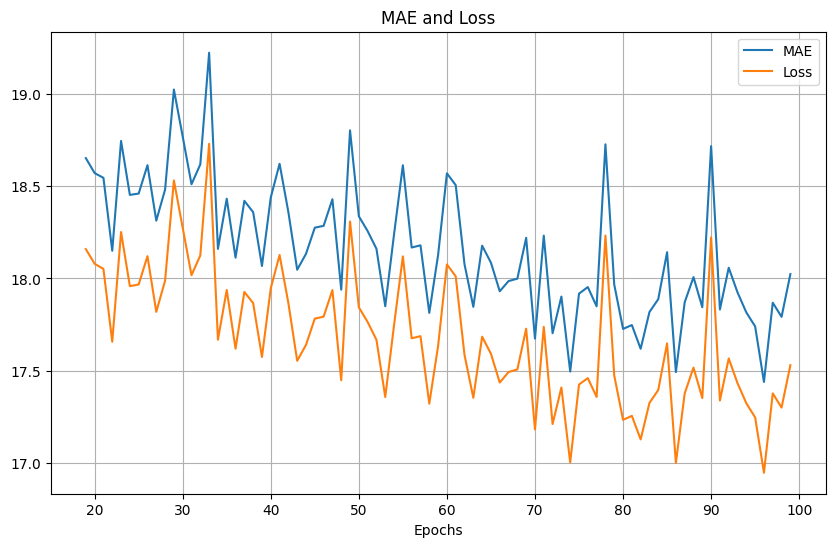

In [15]:
mae=history.history['mae']
loss=history.history['loss']
epochs=range(len(loss))

plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )


In [16]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

8/8 [==============================] - 1s 14ms/step


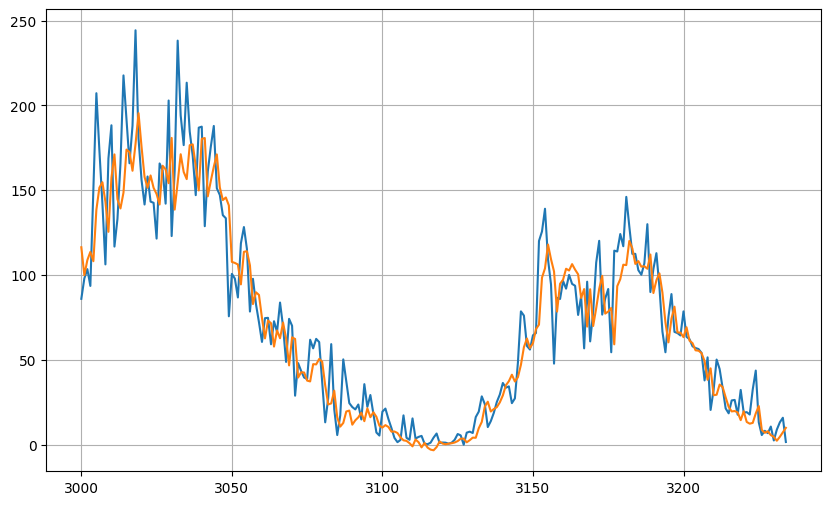

In [17]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [18]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

428.398
14.434818
